## Цель Проекта
- Ваша задача проанализировать данные по страницам вебсайта.
- Определите проблемность вебсайта, если она есть.
- Напишите предварительный вывод по проделанной работе и о том, что вы думаете по поводу того, что за данные попали на анализ

## Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## Импортируйте нужные библиотеки

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import datetime
import plotly.graph_objects as go

## Задачи: 
### Шаг 1. Загрузите необходимые данные

In [5]:
df = pd.read_csv('logs_exp.csv', sep = '\t')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Столбец EventTimestamp в наборе данных использует временные метки Unix, которые представляют количество секунд, прошедших с 1 января 1970 года в 00:00:00 UTC (эпоха Unix).
Чтобы понять, как эти числа превращаются в читаемые даты и время, их нужно преобразовать из Unix времени в обычный формат даты и времени. Давайте преобразуем приведённые временные метки Unix в понятный формат:

In [8]:
pd.to_datetime(df['EventTimestamp'], unit='s')

0        2019-07-25 04:43:36
1        2019-07-25 11:11:42
2        2019-07-25 11:28:47
3        2019-07-25 11:28:47
4        2019-07-25 11:48:42
                 ...        
244121   2019-08-07 21:12:25
244122   2019-08-07 21:13:59
244123   2019-08-07 21:14:43
244124   2019-08-07 21:14:58
244125   2019-08-07 21:15:17
Name: EventTimestamp, Length: 244126, dtype: datetime64[ns]

### Шаг 2. Опишите колонки и строки таблицы.
Перед нами данные по страницам вебсайта.
- Каждая запись соответствует определенному действию пользователя на веб-сайте.
- Колонки - это атрибуты, которые описывают эти взаимодействия.

### Шаг 3. Посчитайте количество уникальных девайсов, сгруппированных по группам (ExpId)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Проверили данные на наполненность. По методу info() видно, что проблем с отсутствующими значениями нет. Формат данных оставляем как есть. 

In [27]:
# Считаем количество уникальных девайсов
unique_devices = df.groupby('ExpId').agg({'DeviceIDHash':'nunique'}).reset_index()
unique_devices.columns = ['ExpId', 'num_of_devices']
unique_devices

,ExpId,num_of_devices
0,246,2489
1,247,2520
2,248,2542


Количества уникальных девайсов не сильно отличаются по группам. Больше всего устройств в экспериментальной группе 248.

### Шаг 4. Посчитайте количество посещений, сгруппированных по группам (ExpId)

In [43]:
visits = df.groupby('ExpId').agg({'EventName':'count'}).reset_index()
visits.columns = ['ExpId','num_of_visits']
visits

,ExpId,num_of_visits
0,246,80304
1,247,78075
2,248,85747


Здесь мы также видим, что большинство посещений было совершено устройствами экспериментальной группы под номером 248.

### Шаг 5. Посчитайте количество посещений в каждую страницу

In [47]:
page_visits = df.groupby('EventName').agg({'DeviceIDHash':'count'}).reset_index().sort_values(by='DeviceIDHash', ascending =False)
page_visits.columns = ['EventName', 'page_visits_num']
page_visits 

,EventName,page_visits_num
1,MainScreenAppear,119205
2,OffersScreenAppear,46825
0,CartScreenAppear,42731
3,PaymentScreenSuccessful,34313
4,Tutorial,1052


Больше всего посещений было на главном экране. Это можно понять, потому что обычно люди переходят с главной страницы на другие страницы. Можно напрямую перейти на другие страницы, если на них есть прямая ссылка.

### Шаг 6. Постройте воронку из библиотеки Plotly (Funnel), которая будет описывать количество посещений в каждую страницу

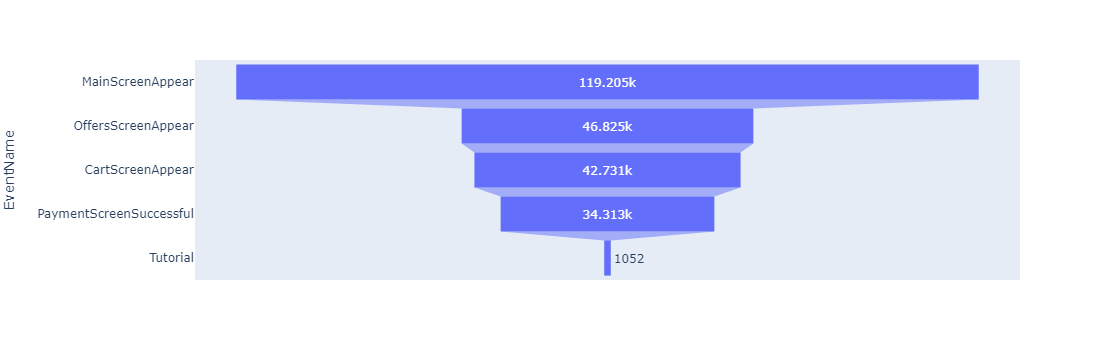

In [48]:
fig = px.funnel(page_visits, x='page_visits_num', y= 'EventName')
fig.show()

Воронка показывает логические шаги пользователей. Первым делом пользователи посещают главную страницу. Таких посещений было 119,205. Из них 46,825 перешли на страницу предложений. Возможно, только 42,731 из них подумали о покупке, и только 34,313 пользователей решились сделать её.

### Шаг 7. Постройте воронку из библиотеки PLotly (Funnel), которая будет описывать количество посещений, а также показывать Конверсию в переходы.

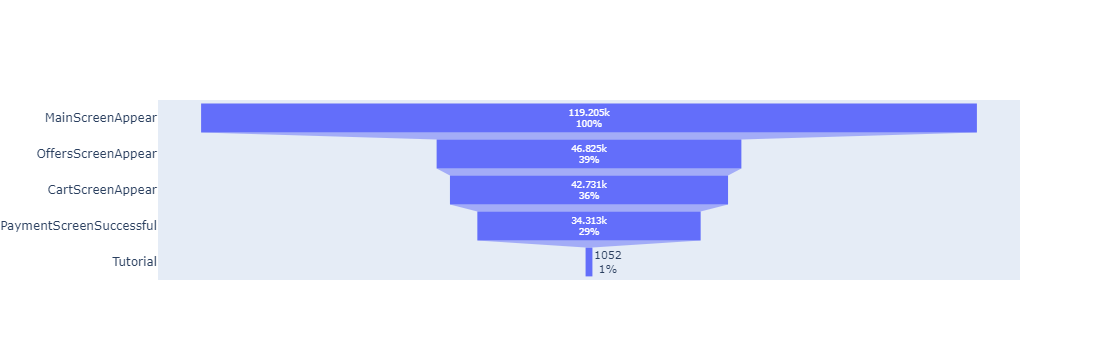

In [51]:
fig = go.Figure(go.Funnel(
    y=page_visits['EventName'],
    x=page_visits['page_visits_num'],
    textinfo="value+percent initial"))
fig.show()

### Опишите свои выводы и ответьте на вопрос: Есть ли проблема в данном веб-сайте и если да, то опишите ваше предположение, в чем проблема?

В этом проекте мы анализировали данные по страницам веб-сайта. Общее количество посещений страниц составляет 244,126. Если человек посетил все страницы, то это считается как 5 посещений. Из названий страниц можно понять, что это веб-сайт электронной коммерции. Хороший ли веб-сайт может показать количество посещений страниц каждого пользователя. Чем больше страниц каждый пользователь посещает, тем лучше веб-сайт, вероятно. Обычно страницу PaymentScreenSuccessful посещают те пользователи, которые до этого посетили страницу CartScreenAppear. Также, чтобы посетить эту страницу, они должны были быть на странице OffersScreenAppear или же MainScreenAppear. Но чтобы попасть на страницу OffersScreenAppear, также нужно посетить главную страницу. То есть первым делом пользователи обычно посещают главную страницу. Из воронки можно видеть, что главную страницу посетили 119,205 раз. Больше 60% пользователей сразу же покидали веб-сайт, даже не попытавшись перейти на страницу предложений. Только 39% пользователей перешли на эту страницу. Из них более 90% пользователей задумывались о покупке, переходя на страницу корзины. Это говорит о том, что страница предложений достаточно привлекательна. И 80% пользователей, посетивших страницу корзины, решились на покупку. Однако этот процент составляет лишь 29% от общего числа пользователей, которые посетили главную страницу. Главная проблема этого веб-сайта заключается в его главной странице. Возможно, она не очень привлекательна, либо дизайн выполнен недостаточно качественно, или же есть проблемы с маркетинговыми стратегиями. Для улучшения показателей эффективности следует провести анализ и оптимизацию главной страницы, чтобы привлечь больше пользователей и увеличить конверсию в покупателей.